## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [3]:
df.head(3)

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365


* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
X = df[['neighbourhood_group', 'latitude', 'longitude', 'room_type',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']]
y = np.log1p(df['price'])

Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.2, random_state=1)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, random_state=1)

Now, use `DictVectorizer` to turn train and validation into matrices:

In [5]:
dv = DictVectorizer()
dtrain = Xtrain.to_dict(orient='records')
dval = Xval.to_dict(orient='records')
dv.fit(dtrain)
XT = dv.transform(dtrain)
XV = dv.transform(dval)
XT.shape, XV.shape

((31292, 15), (7824, 15))

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [6]:
m = DecisionTreeRegressor(max_depth=1)
m.fit(XT,ytrain)

DecisionTreeRegressor(max_depth=1)

[Text(167.4, 163.07999999999998, 'room_type=Entire home/apt <= 0.5\nmse = 0.486\nsamples = 31292\nvalue = 4.738'),
 Text(83.7, 54.360000000000014, 'mse = 0.281\nsamples = 14991\nvalue = 4.291'),
 Text(251.10000000000002, 54.360000000000014, 'mse = 0.32\nsamples = 16301\nvalue = 5.15')]

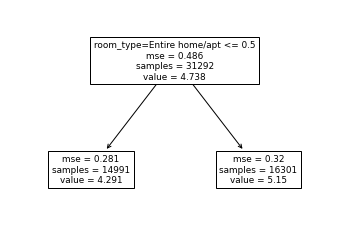

In [7]:
plot_tree(m, feature_names=dv.feature_names_)

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [8]:
def train_rf(XT, ytrain, XV, yval, ntrees=10, maxdep=None):
    m = RandomForestRegressor(n_estimators=ntrees, random_state=1, n_jobs=-1, max_depth=maxdep)
    m.fit(XT, ytrain)
    ypred = m.predict(XT)
    train_rmse = np.mean((ytrain.values - ypred)**2) ** 0.5

    ypred = m.predict(XV)
    val_rmse = np.mean((yval.values - ypred)**2) ** 0.5
    return train_rmse, val_rmse, m

In [9]:
train_rf(XT, ytrain, XV, yval)

(0.1944774304539324,
 0.4591315921621722,
 RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1))

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [15]:
for ntrees in range(10, 201, 10):
    rtrain, rval, m = train_rf(XT, ytrain, XV, yval, ntrees)
    print(ntrees, rval)

10 0.4591315921621722
20 0.44891298190153706
30 0.4439177582773954
40 0.4419269857629046
50 0.4412182050450951
60 0.4404691535276386
70 0.4398259382571694
80 0.4392948885748322
90 0.4390771325419698
100 0.4387105651457843
110 0.43840069391913644
120 0.43810007427132325
130 0.43773463740383456
140 0.4375433086352419
150 0.4375637519553974
160 0.43750525743449453


KeyboardInterrupt: 

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [20]:
for maxdep in [10, 15, 20, 25]:
    best_score = 999999999999999.9
    for ntrees in range(10, 201, 10):
        rtrain, rval, m = train_rf(XT, ytrain, XV, yval, ntrees, maxdep)
        if rval < best_score:
            best_score = rval
    print(maxdep, rval)

10 0.4394625350145503
15 0.43509011936328806
20 0.4361913964014386
25 0.43713129061501815


What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [18]:
from pprint import pprint

_,_,m = train_rf(XT, ytrain, XV, yval, ntrees=10, maxdep=20)
pprint(list(zip(dv.feature_names_, m.feature_importances_)))

[('availability_365', 0.07561198057586682),
 ('calculated_host_listings_count', 0.030444740115403567),
 ('latitude', 0.1470563392412613),
 ('longitude', 0.15721924572066343),
 ('minimum_nights', 0.05358689751255126),
 ('neighbourhood_group=Bronx', 0.00031849238243457606),
 ('neighbourhood_group=Brooklyn', 0.0008913259752591024),
 ('neighbourhood_group=Manhattan', 0.03500253831561246),
 ('neighbourhood_group=Queens', 0.0011945822324246794),
 ('neighbourhood_group=Staten Island', 0.00011465377520570967),
 ('number_of_reviews', 0.04437176031301412),
 ('reviews_per_month', 0.05254889131106728),
 ('room_type=Entire home/apt', 0.3925596969487723),
 ('room_type=Private room', 0.0049920170633734285),
 ('room_type=Shared room', 0.00408683851709001)]


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [16]:
import sys
!{sys.executable} -m pip install xgboost

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 166.7 MB 1.7 MB/s eta 0:00:01


In [17]:
import xgboost as xgb

In [18]:
dtrain = xgb.DMatrix(XT, label=ytrain, feature_names=dv.feature_names_)
dval = xgb.DMatrix(XV, label=yval, feature_names=dv.feature_names_)

In [29]:
for eta in [0.3, 0.1, 0.01]:
    params = {
        'eta': eta,  # learning rate
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        #'eval_metric': 'auc',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

    watchlist = [(dtrain, 'train'), (dval, 'val')]

    model = xgb.train(params, dtrain, evals=watchlist, verbose_eval=1, num_boost_round=100)

    ypred = model.predict(dval)
    print()

[0]	train-rmse:3.02703	val-rmse:3.02557
[1]	train-rmse:2.14613	val-rmse:2.14509
[2]	train-rmse:1.53862	val-rmse:1.53827
[3]	train-rmse:1.12540	val-rmse:1.12612
[4]	train-rmse:0.85055	val-rmse:0.85292
[5]	train-rmse:0.67431	val-rmse:0.67813
[6]	train-rmse:0.56675	val-rmse:0.57296
[7]	train-rmse:0.50401	val-rmse:0.51231
[8]	train-rmse:0.46948	val-rmse:0.47911
[9]	train-rmse:0.45044	val-rmse:0.46159
[10]	train-rmse:0.43985	val-rmse:0.45201
[11]	train-rmse:0.43278	val-rmse:0.44717
[12]	train-rmse:0.42899	val-rmse:0.44410
[13]	train-rmse:0.42636	val-rmse:0.44219
[14]	train-rmse:0.42369	val-rmse:0.44090
[15]	train-rmse:0.42215	val-rmse:0.44048
[16]	train-rmse:0.42041	val-rmse:0.44004
[17]	train-rmse:0.41946	val-rmse:0.43961
[18]	train-rmse:0.41825	val-rmse:0.43975
[19]	train-rmse:0.41627	val-rmse:0.43923
[20]	train-rmse:0.41479	val-rmse:0.43897
[21]	train-rmse:0.41335	val-rmse:0.43922
[22]	train-rmse:0.41285	val-rmse:0.43907
[23]	train-rmse:0.41216	val-rmse:0.43909
[24]	train-rmse:0.41043	va

[1]	train-rmse:4.21088	val-rmse:4.20945
[2]	train-rmse:4.16935	val-rmse:4.16791
[3]	train-rmse:4.12824	val-rmse:4.12680
[4]	train-rmse:4.08756	val-rmse:4.08610
[5]	train-rmse:4.04727	val-rmse:4.04582
[6]	train-rmse:4.00740	val-rmse:4.00595
[7]	train-rmse:3.96793	val-rmse:3.96648
[8]	train-rmse:3.92886	val-rmse:3.92741
[9]	train-rmse:3.89019	val-rmse:3.88874
[10]	train-rmse:3.85191	val-rmse:3.85046
[11]	train-rmse:3.81401	val-rmse:3.81256
[12]	train-rmse:3.77650	val-rmse:3.77504
[13]	train-rmse:3.73938	val-rmse:3.73791
[14]	train-rmse:3.70262	val-rmse:3.70115
[15]	train-rmse:3.66624	val-rmse:3.66475
[16]	train-rmse:3.63023	val-rmse:3.62875
[17]	train-rmse:3.59458	val-rmse:3.59310
[18]	train-rmse:3.55930	val-rmse:3.55781
[19]	train-rmse:3.52437	val-rmse:3.52289
[20]	train-rmse:3.48980	val-rmse:3.48831
[21]	train-rmse:3.45558	val-rmse:3.45408
[22]	train-rmse:3.42170	val-rmse:3.42020
[23]	train-rmse:3.38817	val-rmse:3.38667
[24]	train-rmse:3.35498	val-rmse:3.35346
[25]	train-rmse:3.32213	v

Now change `eta` first to `0.1` and then to `0.01`

In [30]:
s = """[0]	train-rmse:3.02703	val-rmse:3.02557
[1]	train-rmse:2.14613	val-rmse:2.14509
[2]	train-rmse:1.53862	val-rmse:1.53827
[3]	train-rmse:1.12540	val-rmse:1.12612
[4]	train-rmse:0.85055	val-rmse:0.85292
[5]	train-rmse:0.67431	val-rmse:0.67813
[6]	train-rmse:0.56675	val-rmse:0.57296
[7]	train-rmse:0.50401	val-rmse:0.51231
[8]	train-rmse:0.46948	val-rmse:0.47911
[9]	train-rmse:0.45044	val-rmse:0.46159
[10]	train-rmse:0.43985	val-rmse:0.45201
[11]	train-rmse:0.43278	val-rmse:0.44717
[12]	train-rmse:0.42899	val-rmse:0.44410
[13]	train-rmse:0.42636	val-rmse:0.44219
[14]	train-rmse:0.42369	val-rmse:0.44090
[15]	train-rmse:0.42215	val-rmse:0.44048
[16]	train-rmse:0.42041	val-rmse:0.44004
[17]	train-rmse:0.41946	val-rmse:0.43961
[18]	train-rmse:0.41825	val-rmse:0.43975
[19]	train-rmse:0.41627	val-rmse:0.43923
[20]	train-rmse:0.41479	val-rmse:0.43897
[21]	train-rmse:0.41335	val-rmse:0.43922
[22]	train-rmse:0.41285	val-rmse:0.43907
[23]	train-rmse:0.41216	val-rmse:0.43909
[24]	train-rmse:0.41043	val-rmse:0.43914
[25]	train-rmse:0.40974	val-rmse:0.43915
[26]	train-rmse:0.40908	val-rmse:0.43933
[27]	train-rmse:0.40780	val-rmse:0.43920
[28]	train-rmse:0.40710	val-rmse:0.43880
[29]	train-rmse:0.40663	val-rmse:0.43867
[30]	train-rmse:0.40647	val-rmse:0.43867
[31]	train-rmse:0.40625	val-rmse:0.43862
[32]	train-rmse:0.40506	val-rmse:0.43860
[33]	train-rmse:0.40418	val-rmse:0.43856
[34]	train-rmse:0.40390	val-rmse:0.43854
[35]	train-rmse:0.40271	val-rmse:0.43817
[36]	train-rmse:0.40191	val-rmse:0.43801
[37]	train-rmse:0.40094	val-rmse:0.43770
[38]	train-rmse:0.40016	val-rmse:0.43795
[39]	train-rmse:0.39924	val-rmse:0.43740
[40]	train-rmse:0.39886	val-rmse:0.43733
[41]	train-rmse:0.39768	val-rmse:0.43693
[42]	train-rmse:0.39649	val-rmse:0.43677
[43]	train-rmse:0.39549	val-rmse:0.43687
[44]	train-rmse:0.39536	val-rmse:0.43688
[45]	train-rmse:0.39484	val-rmse:0.43699
[46]	train-rmse:0.39446	val-rmse:0.43700
[47]	train-rmse:0.39404	val-rmse:0.43695
[48]	train-rmse:0.39328	val-rmse:0.43699
[49]	train-rmse:0.39300	val-rmse:0.43728
[50]	train-rmse:0.39283	val-rmse:0.43734
[51]	train-rmse:0.39277	val-rmse:0.43736
[52]	train-rmse:0.39195	val-rmse:0.43763
[53]	train-rmse:0.39171	val-rmse:0.43758
[54]	train-rmse:0.39101	val-rmse:0.43785
[55]	train-rmse:0.38981	val-rmse:0.43765
[56]	train-rmse:0.38934	val-rmse:0.43764
[57]	train-rmse:0.38916	val-rmse:0.43766
[58]	train-rmse:0.38816	val-rmse:0.43753
[59]	train-rmse:0.38787	val-rmse:0.43742
[60]	train-rmse:0.38735	val-rmse:0.43758
[61]	train-rmse:0.38702	val-rmse:0.43768
[62]	train-rmse:0.38635	val-rmse:0.43766
[63]	train-rmse:0.38546	val-rmse:0.43742
[64]	train-rmse:0.38525	val-rmse:0.43744
[65]	train-rmse:0.38445	val-rmse:0.43733
[66]	train-rmse:0.38415	val-rmse:0.43752
[67]	train-rmse:0.38398	val-rmse:0.43756
[68]	train-rmse:0.38258	val-rmse:0.43701
[69]	train-rmse:0.38208	val-rmse:0.43717
[70]	train-rmse:0.38157	val-rmse:0.43712
[71]	train-rmse:0.38150	val-rmse:0.43711
[72]	train-rmse:0.38146	val-rmse:0.43717
[73]	train-rmse:0.38121	val-rmse:0.43725
[74]	train-rmse:0.38038	val-rmse:0.43733
[75]	train-rmse:0.37956	val-rmse:0.43737
[76]	train-rmse:0.37880	val-rmse:0.43755
[77]	train-rmse:0.37777	val-rmse:0.43764
[78]	train-rmse:0.37693	val-rmse:0.43796
[79]	train-rmse:0.37614	val-rmse:0.43794
[80]	train-rmse:0.37542	val-rmse:0.43784
[81]	train-rmse:0.37514	val-rmse:0.43781
[82]	train-rmse:0.37437	val-rmse:0.43786
[83]	train-rmse:0.37412	val-rmse:0.43790
[84]	train-rmse:0.37398	val-rmse:0.43785
[85]	train-rmse:0.37362	val-rmse:0.43782
[86]	train-rmse:0.37321	val-rmse:0.43798
[87]	train-rmse:0.37269	val-rmse:0.43788
[88]	train-rmse:0.37256	val-rmse:0.43794
[89]	train-rmse:0.37165	val-rmse:0.43790
[90]	train-rmse:0.37120	val-rmse:0.43795
[91]	train-rmse:0.37055	val-rmse:0.43788
[92]	train-rmse:0.37038	val-rmse:0.43775
[93]	train-rmse:0.37022	val-rmse:0.43776
[94]	train-rmse:0.36998	val-rmse:0.43766
[95]	train-rmse:0.36976	val-rmse:0.43761
[96]	train-rmse:0.36909	val-rmse:0.43737
[97]	train-rmse:0.36835	val-rmse:0.43735
[98]	train-rmse:0.36793	val-rmse:0.43730
[99]	train-rmse:0.36756	val-rmse:0.43724

[0]	train-rmse:3.87166	val-rmse:3.87023
[1]	train-rmse:3.49100	val-rmse:3.48943
[2]	train-rmse:3.14898	val-rmse:3.14727
[3]	train-rmse:2.84180	val-rmse:2.84019
[4]	train-rmse:2.56602	val-rmse:2.56456
[5]	train-rmse:2.31855	val-rmse:2.31741
[6]	train-rmse:2.09664	val-rmse:2.09553
[7]	train-rmse:1.89783	val-rmse:1.89687
[8]	train-rmse:1.71990	val-rmse:1.71921
[9]	train-rmse:1.56081	val-rmse:1.56028
[10]	train-rmse:1.41865	val-rmse:1.41831
[11]	train-rmse:1.29195	val-rmse:1.29177
[12]	train-rmse:1.17926	val-rmse:1.17927
[13]	train-rmse:1.07931	val-rmse:1.07974
[14]	train-rmse:0.99068	val-rmse:0.99147
[15]	train-rmse:0.91253	val-rmse:0.91363
[16]	train-rmse:0.84369	val-rmse:0.84516
[17]	train-rmse:0.78345	val-rmse:0.78538
[18]	train-rmse:0.73084	val-rmse:0.73319
[19]	train-rmse:0.68483	val-rmse:0.68791
[20]	train-rmse:0.64525	val-rmse:0.64899
[21]	train-rmse:0.61100	val-rmse:0.61536
[22]	train-rmse:0.58162	val-rmse:0.58670
[23]	train-rmse:0.55669	val-rmse:0.56236
[24]	train-rmse:0.53532	val-rmse:0.54185
[25]	train-rmse:0.51724	val-rmse:0.52463
[26]	train-rmse:0.50195	val-rmse:0.51004
[27]	train-rmse:0.48925	val-rmse:0.49796
[28]	train-rmse:0.47851	val-rmse:0.48783
[29]	train-rmse:0.46938	val-rmse:0.47915
[30]	train-rmse:0.46183	val-rmse:0.47202
[31]	train-rmse:0.45567	val-rmse:0.46622
[32]	train-rmse:0.45008	val-rmse:0.46140
[33]	train-rmse:0.44560	val-rmse:0.45746
[34]	train-rmse:0.44185	val-rmse:0.45415
[35]	train-rmse:0.43875	val-rmse:0.45146
[36]	train-rmse:0.43594	val-rmse:0.44922
[37]	train-rmse:0.43373	val-rmse:0.44716
[38]	train-rmse:0.43155	val-rmse:0.44543
[39]	train-rmse:0.42993	val-rmse:0.44417
[40]	train-rmse:0.42865	val-rmse:0.44305
[41]	train-rmse:0.42715	val-rmse:0.44224
[42]	train-rmse:0.42603	val-rmse:0.44155
[43]	train-rmse:0.42480	val-rmse:0.44076
[44]	train-rmse:0.42378	val-rmse:0.43998
[45]	train-rmse:0.42274	val-rmse:0.43932
[46]	train-rmse:0.42207	val-rmse:0.43895
[47]	train-rmse:0.42114	val-rmse:0.43849
[48]	train-rmse:0.42023	val-rmse:0.43822
[49]	train-rmse:0.41967	val-rmse:0.43790
[50]	train-rmse:0.41896	val-rmse:0.43757
[51]	train-rmse:0.41844	val-rmse:0.43732
[52]	train-rmse:0.41802	val-rmse:0.43707
[53]	train-rmse:0.41760	val-rmse:0.43693
[54]	train-rmse:0.41711	val-rmse:0.43668
[55]	train-rmse:0.41676	val-rmse:0.43645
[56]	train-rmse:0.41631	val-rmse:0.43630
[57]	train-rmse:0.41590	val-rmse:0.43622
[58]	train-rmse:0.41534	val-rmse:0.43614
[59]	train-rmse:0.41505	val-rmse:0.43609
[60]	train-rmse:0.41492	val-rmse:0.43612
[61]	train-rmse:0.41439	val-rmse:0.43614
[62]	train-rmse:0.41414	val-rmse:0.43608
[63]	train-rmse:0.41373	val-rmse:0.43587
[64]	train-rmse:0.41362	val-rmse:0.43584
[65]	train-rmse:0.41329	val-rmse:0.43574
[66]	train-rmse:0.41319	val-rmse:0.43576
[67]	train-rmse:0.41265	val-rmse:0.43563
[68]	train-rmse:0.41246	val-rmse:0.43565
[69]	train-rmse:0.41205	val-rmse:0.43562
[70]	train-rmse:0.41158	val-rmse:0.43545
[71]	train-rmse:0.41140	val-rmse:0.43545
[72]	train-rmse:0.41112	val-rmse:0.43538
[73]	train-rmse:0.41075	val-rmse:0.43537
[74]	train-rmse:0.41059	val-rmse:0.43544
[75]	train-rmse:0.41018	val-rmse:0.43533
[76]	train-rmse:0.40974	val-rmse:0.43526
[77]	train-rmse:0.40949	val-rmse:0.43524
[78]	train-rmse:0.40927	val-rmse:0.43528
[79]	train-rmse:0.40894	val-rmse:0.43514
[80]	train-rmse:0.40876	val-rmse:0.43517
[81]	train-rmse:0.40854	val-rmse:0.43511
[82]	train-rmse:0.40829	val-rmse:0.43517
[83]	train-rmse:0.40783	val-rmse:0.43495
[84]	train-rmse:0.40775	val-rmse:0.43495
[85]	train-rmse:0.40747	val-rmse:0.43483
[86]	train-rmse:0.40736	val-rmse:0.43484
[87]	train-rmse:0.40715	val-rmse:0.43475
[88]	train-rmse:0.40688	val-rmse:0.43476
[89]	train-rmse:0.40661	val-rmse:0.43477
[90]	train-rmse:0.40656	val-rmse:0.43480
[91]	train-rmse:0.40613	val-rmse:0.43480
[92]	train-rmse:0.40595	val-rmse:0.43481
[93]	train-rmse:0.40585	val-rmse:0.43473
[94]	train-rmse:0.40575	val-rmse:0.43476
[95]	train-rmse:0.40556	val-rmse:0.43481
[96]	train-rmse:0.40551	val-rmse:0.43482
[97]	train-rmse:0.40532	val-rmse:0.43474
[98]	train-rmse:0.40507	val-rmse:0.43472
[99]	train-rmse:0.40467	val-rmse:0.43459

[0]	train-rmse:4.25284	val-rmse:4.25141

[1]	train-rmse:4.21088	val-rmse:4.20945
[2]	train-rmse:4.16935	val-rmse:4.16791
[3]	train-rmse:4.12824	val-rmse:4.12680
[4]	train-rmse:4.08756	val-rmse:4.08610
[5]	train-rmse:4.04727	val-rmse:4.04582
[6]	train-rmse:4.00740	val-rmse:4.00595
[7]	train-rmse:3.96793	val-rmse:3.96648
[8]	train-rmse:3.92886	val-rmse:3.92741
[9]	train-rmse:3.89019	val-rmse:3.88874
[10]	train-rmse:3.85191	val-rmse:3.85046
[11]	train-rmse:3.81401	val-rmse:3.81256
[12]	train-rmse:3.77650	val-rmse:3.77504
[13]	train-rmse:3.73938	val-rmse:3.73791
[14]	train-rmse:3.70262	val-rmse:3.70115
[15]	train-rmse:3.66624	val-rmse:3.66475
[16]	train-rmse:3.63023	val-rmse:3.62875
[17]	train-rmse:3.59458	val-rmse:3.59310
[18]	train-rmse:3.55930	val-rmse:3.55781
[19]	train-rmse:3.52437	val-rmse:3.52289
[20]	train-rmse:3.48980	val-rmse:3.48831
[21]	train-rmse:3.45558	val-rmse:3.45408
[22]	train-rmse:3.42170	val-rmse:3.42020
[23]	train-rmse:3.38817	val-rmse:3.38667
[24]	train-rmse:3.35498	val-rmse:3.35346
[25]	train-rmse:3.32213	val-rmse:3.32060
[26]	train-rmse:3.28961	val-rmse:3.28806
[27]	train-rmse:3.25743	val-rmse:3.25588
[28]	train-rmse:3.22557	val-rmse:3.22403
[29]	train-rmse:3.19404	val-rmse:3.19249
[30]	train-rmse:3.16283	val-rmse:3.16127
[31]	train-rmse:3.13193	val-rmse:3.13036
[32]	train-rmse:3.10135	val-rmse:3.09978
[33]	train-rmse:3.07108	val-rmse:3.06950
[34]	train-rmse:3.04113	val-rmse:3.03955
[35]	train-rmse:3.01147	val-rmse:3.00991
[36]	train-rmse:2.98212	val-rmse:2.98057
[37]	train-rmse:2.95307	val-rmse:2.95153
[38]	train-rmse:2.92431	val-rmse:2.92281
[39]	train-rmse:2.89586	val-rmse:2.89437
[40]	train-rmse:2.86768	val-rmse:2.86624
[41]	train-rmse:2.83981	val-rmse:2.83837
[42]	train-rmse:2.81221	val-rmse:2.81081
[43]	train-rmse:2.78490	val-rmse:2.78351
[44]	train-rmse:2.75786	val-rmse:2.75651
[45]	train-rmse:2.73110	val-rmse:2.72979
[46]	train-rmse:2.70462	val-rmse:2.70332
[47]	train-rmse:2.67841	val-rmse:2.67713
[48]	train-rmse:2.65247	val-rmse:2.65121
[49]	train-rmse:2.62679	val-rmse:2.62555
[50]	train-rmse:2.60138	val-rmse:2.60017
[51]	train-rmse:2.57623	val-rmse:2.57503
[52]	train-rmse:2.55133	val-rmse:2.55017
[53]	train-rmse:2.52670	val-rmse:2.52555
[54]	train-rmse:2.50232	val-rmse:2.50118
[55]	train-rmse:2.47819	val-rmse:2.47707
[56]	train-rmse:2.45431	val-rmse:2.45322
[57]	train-rmse:2.43067	val-rmse:2.42960
[58]	train-rmse:2.40728	val-rmse:2.40623
[59]	train-rmse:2.38413	val-rmse:2.38309
[60]	train-rmse:2.36122	val-rmse:2.36019
[61]	train-rmse:2.33854	val-rmse:2.33753
[62]	train-rmse:2.31610	val-rmse:2.31512
[63]	train-rmse:2.29389	val-rmse:2.29293
[64]	train-rmse:2.27191	val-rmse:2.27099
[65]	train-rmse:2.25016	val-rmse:2.24925
[66]	train-rmse:2.22864	val-rmse:2.22775
[67]	train-rmse:2.20734	val-rmse:2.20647
[68]	train-rmse:2.18626	val-rmse:2.18540
[69]	train-rmse:2.16539	val-rmse:2.16456
[70]	train-rmse:2.14475	val-rmse:2.14394
[71]	train-rmse:2.12432	val-rmse:2.12353
[72]	train-rmse:2.10410	val-rmse:2.10331
[73]	train-rmse:2.08409	val-rmse:2.08332
[74]	train-rmse:2.06429	val-rmse:2.06354
[75]	train-rmse:2.04470	val-rmse:2.04397
[76]	train-rmse:2.02531	val-rmse:2.02460
[77]	train-rmse:2.00613	val-rmse:2.00543
[78]	train-rmse:1.98715	val-rmse:1.98647
[79]	train-rmse:1.96836	val-rmse:1.96770
[80]	train-rmse:1.94977	val-rmse:1.94913
[81]	train-rmse:1.93138	val-rmse:1.93076
[82]	train-rmse:1.91318	val-rmse:1.91259
[83]	train-rmse:1.89517	val-rmse:1.89461
[84]	train-rmse:1.87736	val-rmse:1.87680
[85]	train-rmse:1.85972	val-rmse:1.85921
[86]	train-rmse:1.84228	val-rmse:1.84180
[87]	train-rmse:1.82501	val-rmse:1.82453
[88]	train-rmse:1.80793	val-rmse:1.80746
[89]	train-rmse:1.79103	val-rmse:1.79059
[90]	train-rmse:1.77431	val-rmse:1.77389
[91]	train-rmse:1.75776	val-rmse:1.75738
[92]	train-rmse:1.74139	val-rmse:1.74102
[93]	train-rmse:1.72519	val-rmse:1.72483
[94]	train-rmse:1.70917	val-rmse:1.70881
[95]	train-rmse:1.69330	val-rmse:1.69298
[96]	train-rmse:1.67761	val-rmse:1.67731
[97]	train-rmse:1.66209	val-rmse:1.66180
[98]	train-rmse:1.64674	val-rmse:1.64647
[99]	train-rmse:1.63155	val-rmse:1.63129
"""

In [34]:
import re

results = re.findall('val-rmse:(.+)', s)
results = list(map(float, results))
len(results)

300

In [36]:
print("0.3", min(results[:100]))
print("0.1", min(results[100:200]))
print("0.01", min(results[200:]))

0.3 0.43677
0.1 0.43459
0.01 1.63129


In [ ]:
# done

What's the best eta?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

